## Introduction

The high rate of traffic accidents in Indonesia, particularly those involving motorcycles, has become a serious issue that requires urgent attention. One of the main contributing factors to the high fatality rate in these accidents is traffic violations, such as riding without wearing a protective helmet.

This project aims to develop an automated detection system to monitor helmet usage among motorcycle riders on public roads using **deep learning-based object detection methods**. The goal is to support more efficient and systematic traffic surveillance efforts and serve as an initial step toward implementing an **AI-powered automated e-Ticketing (e-Tilang) system**.

## Setup

In [2]:
import os
os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices=false"

import tensorflow as tf
from tensorflow import keras

import keras_cv
from keras_cv import bounding_box
from keras_cv import visualization

from tqdm.auto import tqdm
import xml.etree.ElementTree as ET
from roboflow import Roboflow

## Hyperparameters

In [3]:
SPLIT_RATIO = 0.2
BATCH_SIZE = 4
LEARNING_RATE = 0.001
EPOCH = 5
GLOBAL_CLIPNORM = 10.0

## Load Data

In [4]:
class_ids = [
    "motor",
    "helm",
    "non-helm"
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

# Path to images and annotations
path_images = r"./Dataset/helmonzy-5"
path_annot = r"./Dataset/helmonzy-5"

# Get all XML file paths in path_annot and sort them
xml_files = sorted(
    [
        os.path.join(path_annot, file_name)
        for file_name in os.listdir(path_annot)
        if file_name.endswith(".xml")
    ]
)

# Get all JPEG image file paths in path_images and sort them
jpg_files = sorted(
    [
        os.path.join(path_images, file_name)
        for file_name in os.listdir(path_images)
        if file_name.endswith(".jpg")
    ]
)

In [5]:
def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    image_name = root.find("filename").text
    image_path = os.path.join(path_images, image_name)

    boxes = []
    classes = []
    for obj in root.iter("object"):
        cls = obj.find("name").text
        classes.append(cls)

        bbox = obj.find("bndbox")
        xmin = float(bbox.find("xmin").text)
        ymin = float(bbox.find("ymin").text)
        xmax = float(bbox.find("xmax").text)
        ymax = float(bbox.find("ymax").text)
        boxes.append([xmin, ymin, xmax, ymax])

    class_ids = [
        list(class_mapping.keys())[list(class_mapping.values()).index(cls)]
        for cls in classes
    ]
    return image_path, boxes, class_ids


image_paths = []
bbox = []
classes = []
for xml_file in tqdm(xml_files):
    image_path, boxes, class_ids = parse_annotation(xml_file)
    image_paths.append(image_path)
    bbox.append(boxes)
    classes.append(class_ids)

  0%|          | 0/3615 [00:00<?, ?it/s]

100%|██████████| 3615/3615 [00:34<00:00, 103.46it/s]


In [6]:
bbox = tf.ragged.constant(bbox)
classes = tf.ragged.constant(classes)
image_paths = tf.ragged.constant(image_paths)

data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))

Splitting data in training and validation data

In [7]:
# Determine the number of validation samples
num_val = int(len(xml_files) * SPLIT_RATIO)

# Split the dataset into train and validation sets
val_data = data.take(num_val)
train_data = data.skip(num_val)

In [8]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image


def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.ragged.map_flat_values(tf.cast, classes, tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}


## Data Augmentation


In [9]:
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        keras_cv.layers.RandomShear(
            x_factor=0.2, y_factor=0.2, bounding_box_format="xyxy"
        ),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="xyxy"
        ),
    ]
)

In [10]:
def ragged_to_dense(inputs):
    boxes = inputs["bounding_boxes"]["boxes"].to_tensor(default_value=0.0)
    classes = inputs["bounding_boxes"]["classes"].to_tensor(default_value=-1.0)

    bounding_boxes = {
        "boxes": boxes,
        "classes": classes
    }

    return inputs["images"], bounding_boxes


## Creating Training Dataset

In [11]:
train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(ragged_to_dense, num_parallel_calls=tf.data.AUTOTUNE)

# Prefetch
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

## Creating Validation Dataset

In [12]:
resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(0.75, 1.3),
    bounding_box_format="xyxy",
)

val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(ragged_to_dense, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

## Visualization

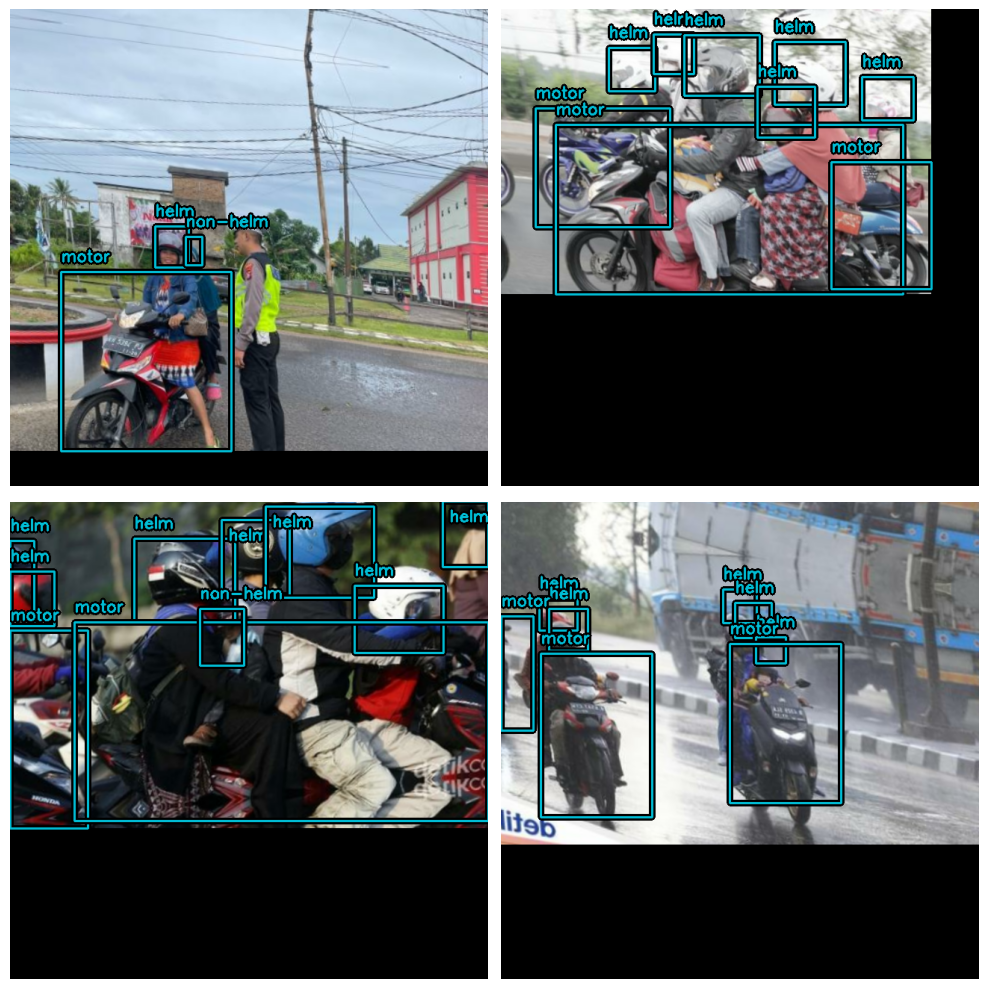

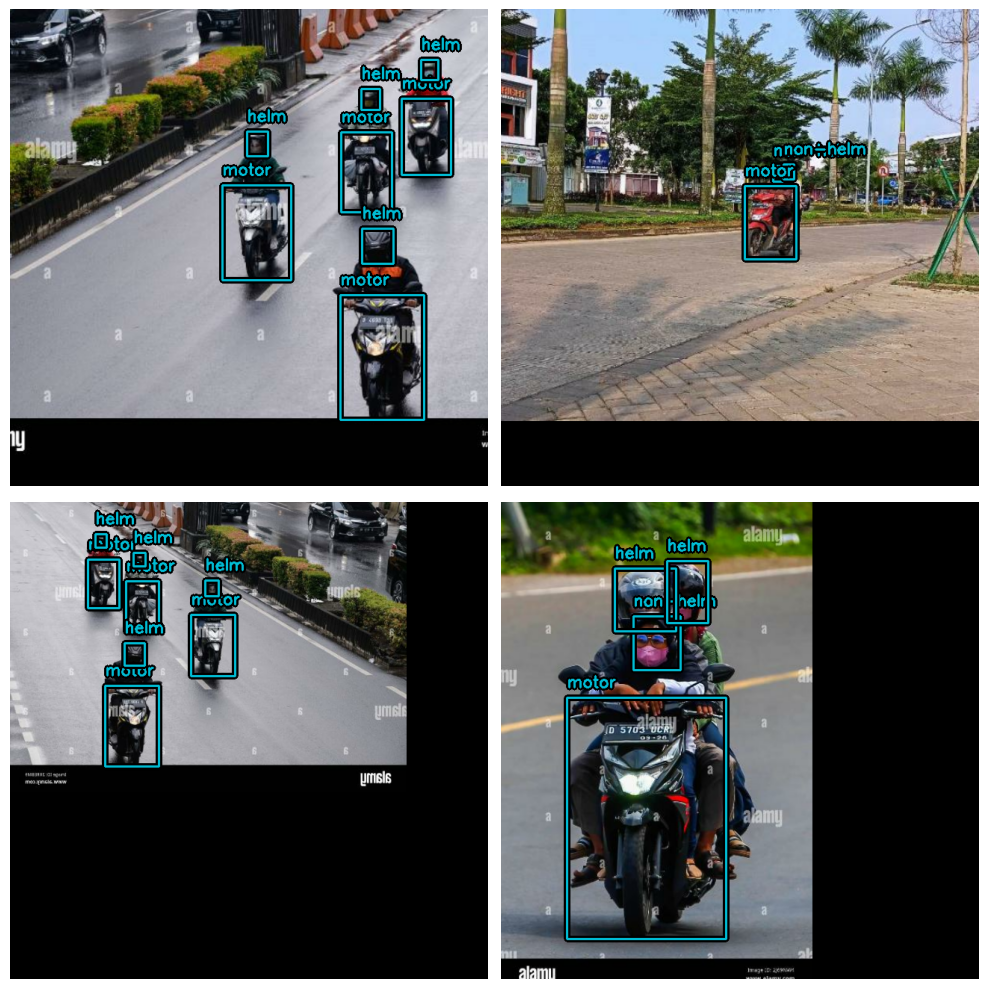

In [13]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )


visualize_dataset(
    train_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

visualize_dataset(
    val_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

We need to extract the inputs from the preprocessing dictionary and get them ready to be
fed into the model.

In [ ]:

#def dict_to_tuple(inputs):
#    return inputs["images"], inputs["bounding_boxes"]


#train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
#train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

#val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
#val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

## Creating Model

In [14]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_s_backbone_coco"  # We will use yolov8 small backbone with coco weights
)

In [15]:
yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format="xyxy",
    backbone=backbone,
    fpn_depth=1,
)

## Compile the Model

In [16]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM,
)

yolo.compile(
    optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou"
)

## COCO Metric Callback

In [36]:

class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="xyxy",
            evaluate_freq=1e9,
        )

        self.save_path = save_path
        self.best_map = -1.0

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)

        current_map = metrics["MaP"]
        if current_map > self.best_map:
            self.best_map = current_map
            self.model.save(self.save_path)  # Save the model when mAP improves

        return logs


In [37]:
for x, y in train_ds.take(1):
    print("Image shape:", x.shape)
    print("Label keys:", y.keys())
    print("Boxes:", y["boxes"])
    print("Classes:", y["classes"])


Image shape: (4, 640, 640, 3)
Label keys: dict_keys(['boxes', 'classes'])
Boxes: tf.Tensor(
[[[524.65656    90.21474   613.        185.25171  ]
  [500.68762   121.780235  558.3102    180.1977   ]
  [312.5628     82.311554  412.99292   173.00839  ]
  [255.13289    61.284958  321.66122   142.47835  ]
  [167.48543    45.433685  275.95648   143.5018   ]
  [  2.7416766  31.851042   89.909424  107.07944  ]
  [ 88.11713   126.098335  177.09236   199.55908  ]
  [461.2079    182.73358   613.        345.       ]
  [  9.135619  162.71152   461.96988   345.       ]
  [296.66516   155.75084   339.17892   216.75595  ]]

 [[560.8573     10.024085  640.        121.06091  ]
  [532.7098     54.502663  600.4475    122.81656  ]
  [307.39905    36.79226   425.6809    142.59207  ]
  [240.28925    24.03924   318.2219    119.31123  ]
  [134.6554     17.220688  262.40524   131.62215  ]
  [  0.         30.980125   41.805855  118.64336  ]
  [ 39.28318   128.73724   144.21152   214.2486   ]
  [483.141     126.134

In [38]:
yolo.summary()

Model: "yolov8_detector"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 model (Functional)          {'P3': (None, None, None,    5089760   ['input_2[0][0]']             
                             128),                                                                
                              'P4': (None, None, None,                                            
                             256),                                                                
                              'P5': (None, None, None,                                            
                             512)}                                                  

## Train the Model

In [39]:
yolo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3,
    #callbacks=[EvaluateCOCOMetricsCallback(val_ds, "model.h5")],
)

Epoch 1/3
723/723 [==============================] - 1297s 2s/step - loss: 3.4628 - box_loss: 2.5685 - class_loss: 0.8943 - val_loss: 4.3373 - val_box_loss: 3.0643 - val_class_loss: 1.2730
Epoch 2/3
723/723 [==============================] - 1292s 2s/step - loss: 3.4032 - box_loss: 2.5392 - class_loss: 0.8639 - val_loss: 4.2327 - val_box_loss: 3.0393 - val_class_loss: 1.1935
Epoch 3/3
723/723 [==============================] - 1533s 2s/step - loss: 3.3070 - box_loss: 2.4630 - class_loss: 0.8440 - val_loss: 4.4400 - val_box_loss: 3.2058 - val_class_loss: 1.2341


## Visualize Predictions

1/1 [==============================] - 1s 505ms/step


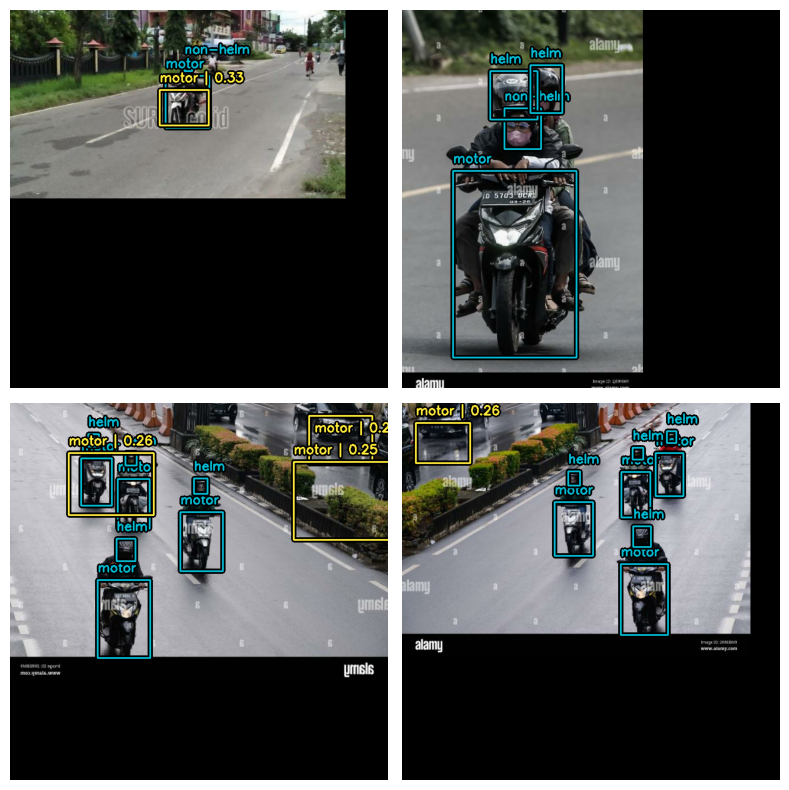

In [40]:
def visualize_detections(model, dataset, bounding_box_format):
    # Ambil satu batch dari dataset
    batch = next(iter(dataset.take(1)))

    images, y_true = next(iter(dataset.take(1)))


    # Prediksi menggunakan model
    y_pred = model.predict(images)

    # Langsung plot tanpa ubah ke ragged
    keras_cv.visualization.plot_bounding_box_gallery(
        images=images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        rows=2,
        cols=2,
        scale=4,
        font_scale=0.7,
        class_mapping=class_mapping,
    )


visualize_detections(yolo, dataset=val_ds, bounding_box_format="xyxy")

In [ ]:
!pip install pipreqs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pipreqs "/content/drive/MyDrive/Colab Notebooks/yolov8/" --scan-notebooks

ERROR: Failed on file: /content/drive/MyDrive/Colab Notebooks/yolov8/yolov8 (2).ipynb
Traceback (most recent call last):
  File "/usr/local/bin/pipreqs", line 8, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pipreqs/pipreqs.py", line 609, in main
    init(args)
  File "/usr/local/lib/python3.11/dist-packages/pipreqs/pipreqs.py", line 533, in init
    candidates = get_all_imports(
                 ^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pipreqs/pipreqs.py", line 153, in get_all_imports
    raise exc
  File "/usr/local/lib/python3.11/dist-packages/pipreqs/pipreqs.py", line 139, in get_all_imports
    tree = ast.parse(contents)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ast.py", line 50, in parse
    return compile(source, filename, mode, flags,
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<unknown>", line 707
    pipreqs "/content/drive/MyDrive/Colab Notebooks/Demo" --scan-noteboo